## Setting up the AB Testing Experiment

### First, let's understand the data we have

Say we have an existing version of our product. (Could be a website, or something edible with 2 different flavors, or two colors of our product etc.)

We want to try a make a small variation and see if it will perform better with our customers. Rather than testing it on a large set of customers, we will test it on **10% of our customers**. 
The variable `n_customers_opt1` denotes the number of customers who were shown the original product (version 1). Of those, `success_v1` are the number of customers who "liked" it. (In the case of a website these are the people who clicked on a link, or responded to some call to action.)
Similarly, a smaller fraction `n_customers_v2` were shown product variant 2, and `success_v2` clicked or liked that variant.


- n_customers_op1 = # customers who were shown Option 1 of the product
- n_customers_op2 = # customers who were shown Option 2 of the product
- success_v1 = # customers who liked Option 1
- success_v2 = # customers who liked Option 2


### Data that we've collected

In [1]:
%matplotlib inline
import pymc3 as pm
#import seaborn as sns
from theano import config
config.warn.round=False

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\ramna\Anaconda3\envs\b2\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
n_customers_opt1 = 900
success_v1 = 59  # Number of customers who liked option 1

n_customers_opt2 = 100
success_v2 = 7  # Number of customers who like option 2

### Question
Can we conclude that Variant B (opt2) is appealing to more customers than Variant A (opt1)?

To know the answer, we have to construct a Bayesian model, set up the priors and likelihood and see how the two options of our product perform (in a probabilistic sense).

In [3]:
with pm.Model() as model: # context management
    # define priors
    prior_opt1 = pm.Beta('prior_opt1', alpha=2, beta=2)
    prior_opt2 = pm.Beta('prior_opt2', alpha=2, beta=2)

    # define likelihood
    like_v1 = pm.Binomial('likelihood_opt1', n=n_customers_opt1, p=prior_opt1, observed=success_v1)
    like_v2 = pm.Binomial('likelihood_opt2', n=n_customers_opt2, p=prior_opt2, observed=success_v2)
    
    # Since we want to know if opt2 is better than opt1, let's compare them, element by element
    pm.Deterministic('difference', prior_opt2 - prior_opt1)
    pm.Deterministic('ratio', (prior_opt2/prior_opt1))

    # inference
    trace = pm.sample(draws=5000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior_opt2, prior_opt1]
Sampling 4 chains, 0 divergences: 100%|██████████████████████████████████████| 22000/22000 [01:22<00:00, 267.06draws/s]


C:\Users\ramna\Anaconda3\envs\b2\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\ramna\Anaconda3\envs\b2\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\ramna\Anaconda3\envs\b2\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\ramna\Anaconda3\envs\b2\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\ramna\Anaconda3\envs\b2\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument

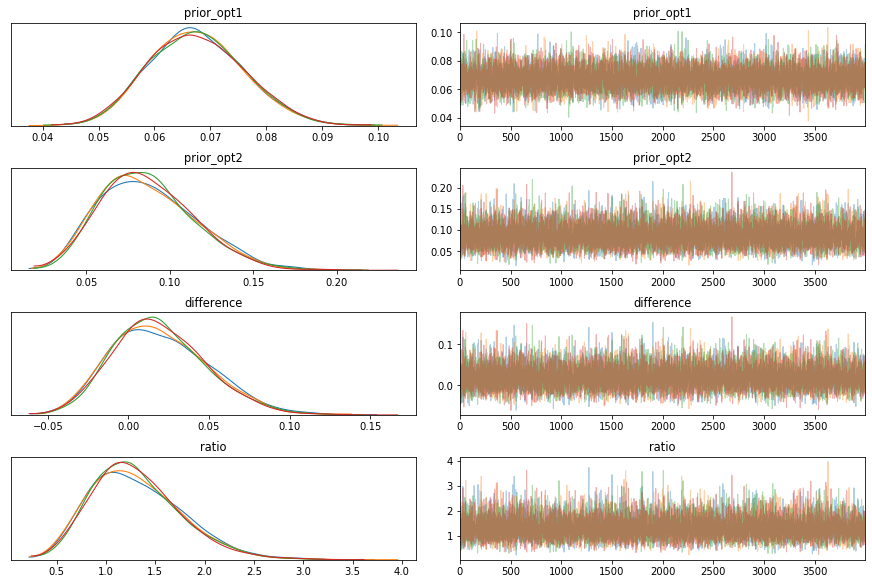

In [4]:
#let's throw away the first 1000 trace samples
pm.traceplot(trace[1000:]); 
#pm.traceplot(trace);

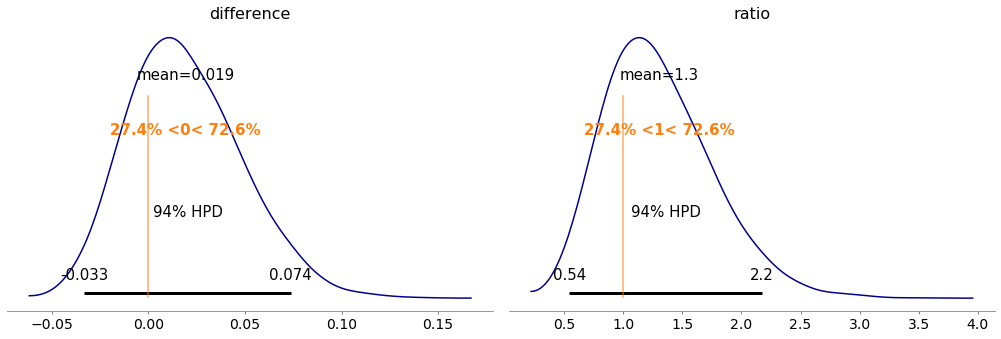

In [5]:
pm.plot_posterior(trace[1000:], var_names=['difference', 'ratio'], 
                      ref_val=[0,1], color='darkblue');


### Conclusion

From our analysis, we can see that Option 2 does have a slight positive impact with the customers who were shown it. However, the difference is small (mean difference is 0.019). And by looking at where the bulk of the distribution lies, we can tell that the `difference` could be in the range [-0.031, 0.076]. Since the Confidence percentage is at most 73.6%, we can't say anything definitively. At best, we can ask for more data to be collected.

### References & Credits

- Thiago Balbo's Blog post on AB Testing is simple and very accessible: https://medium.com/@thibalbo/coding-bayesian-ab-tests-in-python-e89356b3f4bd


In [6]:
model

These are some of the ways in which you can query the trace (to understand the posterior)

In [7]:
trace.get_values('prior_opt1')
trace.stat_names
trace.chains
trace.nchains
trace.point(idx=100)
trace.varnames

['prior_opt1_logodds__',
 'prior_opt2_logodds__',
 'prior_opt1',
 'prior_opt2',
 'difference',
 'ratio']